In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from pathlib import Path, PurePath, WindowsPath
from operator import itemgetter
import tensorflow as tf
from tensorflow.python.framework import ops
#from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
from tf_utils import load_dataset, convert_to_one_hot, predict

from image_dataset_load import *

import autodiff as ad
import initializers as init

%matplotlib inline

In [3]:
def show_image(data, label, ind, dimension, print_class=False):
    w, h = dimension
    test_image = data[:, ind].reshape(h, w, 3)
    test_label = label[:, ind]    
    if print_class:
        print(test_label, np.argmax(test_label))
    plt.imshow(test_image)
    plt.show()
    return np.argmax(test_label)

In [4]:
def one_hot(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    
    C = tf.constant(C, name='C')
    
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot    

In [5]:
#X, Y = load_img_dataset()
X, Y = loadImgsLabels([(r"test\size_80x80\1", 0), (r"test\size_80x80\2", 1), (r"test\size_80x80\3", 2)], (80, 80))
X, Y = randomize_std(X, Y)

num_classes = 3

#train_X, train_Y, dev_X, dev_Y, test_X, test_Y = split_train_dev_test(X, Y, 700, 800)
train_X, train_Y, test_X, test_Y = split_train_test(X, Y, 700)

train_Y = one_hot(train_Y, num_classes)
#dev_Y = one_hot(dev_Y, num_classes)
test_Y = one_hot(test_Y, num_classes)

train_Y = train_Y.reshape((num_classes, train_Y.shape[2]))
#dev_Y = dev_Y.reshape((num_classes, dev_Y.shape[2]))
test_Y = test_Y.reshape((num_classes, test_Y.shape[2]))

#aa = loadImgs(r"test\3", )

print("train_X shape, train_Y shape ", train_X.shape, train_Y.shape)
#print(dev_X.shape, dev_Y.shape)
#print("dev_X shape, dev_Y shape ", dev_X.shape, dev_Y.shape)
print("test_X shape, test_Y shape ", test_X.shape, test_Y.shape)

#show_image(test_X, test_Y, 51)

(310, 80, 80, 3)
(653, 80, 80, 3)
(896, 80, 80, 3)
train_X shape, train_Y shape  (19200, 700) (3, 700)
test_X shape, test_Y shape  (19200, 196) (3, 196)


[ 0.  0.  1.] 2


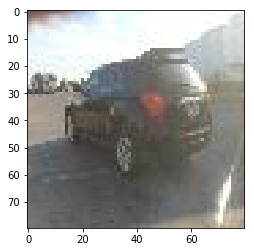

2

In [6]:
show_image(train_X, train_Y, 1, (80, 80), print_class=True)

In [7]:
def random_mini_batches(X, Y, batch_size=10, seed=0):    
    """
    Shuffle the input X and produce mini batches in size of batch_size
    
    Arguments:
    X - input.  dimension ( input features, no of examples )
    Y - labels
    batch_size - size of the mini-batch
    seed - seed to randomize the X before splitting it into mini-batches

    Returns:
    batches of X and Y split into size of batch_size
    """   
    
    
    np.random.seed(seed)
    
    m = X.shape[1]
    permute = list(np.random.permutation(m))
    
    X = X[:, permute]
    Y = Y[:, permute]     
    
    
    a = list(range(0, m, batch_size))
    b = list(range(batch_size, m, batch_size))    
    b.append(m)
    
    for (start, end) in zip(a, b):        
        yield X[:, start:end], Y[:, start:end]

In [10]:
learn_rate = 0.005
# w_val_init1 = np.random.randn(100, train_X.shape[0])
# w_val_init2 = np.random.randn(20, 100)
# w_val_init3 = np.random.randn(3, 20)

#W1, W2, W3 = ad.Variable(w_val_init1, name = "W1"), ad.Variable(w_val_init2, name = "W2"), ad.Variable(w_val_init3, name = "W3")
W1 = ad.Variable(name = "W1", shape = (100, train_X.shape[0]), initializer = init.xavier_initializer())
W2 = ad.Variable(name = "W2", shape = (20, 100), initializer = init.xavier_initializer())
W3 = ad.Variable(name = "W3", shape = (3, 20), initializer = init.xavier_initializer())

x, labels = ad.placeholder(name = "x"), ad.placeholder(name = "labels")

In [11]:
import train as tr

Z1 = ad.matmul(W1, x)
A1 = ad.relu(Z1)
Z2 = ad.matmul(W2, A1)
A2 = ad.relu(Z2)
Z3 = ad.matmul(W3, A2)


#cost = ad.reduce_mean( ad.softmax_with_cross_entropy(Z3, labels) )
cost = ad.reduce_mean( ad.softmax_with_cross_entropy(Z3, labels) )
optimizer = tr.GradientDescentOptimizer(learn_rate).minimize(cost)
optimizer.append(cost)
print("optimizer length ", len(optimizer))

executor = ad.Executor(optimizer)

seed = 0
costs = []   # to track the costs
epochs = 50
mini_batch_size = 10
    
for epoch in range(epochs):
    epoch_cost = 0
    seed += 1
    
    for (batch_X, batch_Y) in random_mini_batches(train_X, train_Y, mini_batch_size, seed):
        curr_batch_size = batch_X.shape[1]
        
        _, _, _, minibatch_cost = executor.run(feed_dict = {x : batch_X, labels : batch_Y})
        epoch_cost += minibatch_cost/curr_batch_size
        
    if epoch % 1 == 0:
        print("Cost after epoch %i: %f" % (epoch, epoch_cost))                

trainable_vars  [W1, W2, W3]
optimizer length  4
Cost after epoch 0: 12.312207
Cost after epoch 1: 9.594357
Cost after epoch 2: 8.999662
Cost after epoch 3: 8.329410
Cost after epoch 4: 7.679460
Cost after epoch 5: 7.397725
Cost after epoch 6: 7.215477
Cost after epoch 7: 6.729171
Cost after epoch 8: 5.947331
Cost after epoch 9: 5.974598
Cost after epoch 10: 6.336961
Cost after epoch 11: 5.041231
Cost after epoch 12: 5.252138
Cost after epoch 13: 4.748239
Cost after epoch 14: 4.523609
Cost after epoch 15: 4.274789
Cost after epoch 16: 4.642510
Cost after epoch 17: 4.204317
Cost after epoch 18: 3.674904
Cost after epoch 19: 3.758512
Cost after epoch 20: 2.950364
Cost after epoch 21: 3.133182
Cost after epoch 22: 2.758582
Cost after epoch 23: 2.454032
Cost after epoch 24: 2.152804
Cost after epoch 25: 1.820848
Cost after epoch 26: 2.655636
Cost after epoch 27: 1.793796
Cost after epoch 28: 1.549718
Cost after epoch 29: 1.606435
Cost after epoch 30: 1.848762
Cost after epoch 31: 1.623394


In [20]:
Z3_val = executor.compute_value([Z3], feed_dict = {x : train_X[:, 1]})
np.argmax(Z3_val)

2

In [18]:
def create_placeholders(num_features, classes):
    """
    Creates the placeholders for training data X and traininig class labels Y
                     
    Arguments:
    num_inputs -- no. of input features 
    classes -- number of classes
    
    Returns: 
    X and Y placeholders
    """
    
    X = tf.placeholder(tf.float32, shape=(num_features, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(classes, None), name='Y')
    
    return X, Y    

In [12]:
def initialize_parameters(num_features, classes):
    """
    initialize the wts and biases for the network
    
    Arguments:
    num_inputs -- no. of input features 
    classes -- number of classes
    
    Returns :
    dictionary of tensors containing W1, b1, W2, b2, W3, b3    
    """
    
    random_init = tf.random_normal_initializer()
    xavier_init = tf.contrib.layers.xavier_initializer(seed = 1)
    
    W1 = tf.get_variable("W1", [100, num_features], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [300, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable("W2", [20, 100], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [100, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable("W3", [classes, 20], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [classes, 1], initializer = tf.zeros_initializer())

    parameters = {"W1":W1, "b1":b1,
                  "W2":W2, "b2":b2,
                  "W3":W3, "b3":b3
                 }
    
#     W1 = tf.Variable(w_val_init1, dtype=tf.float32, name='W1')
#     W2 = tf.Variable(w_val_init2, dtype=tf.float32, name='W2')
#     W3 = tf.Variable(w_val_init3, dtype=tf.float32, name='W3')
    
#     parameters = {"W1":W1, "W2":W2, "W3":W3 }
    
    return parameters

In [13]:
def forward_prop(X, parameters):
    """
    Computes the forward propagation.
    
    Arguments:
    X -- input data of dimension ( input features, no of examples )
    parameters -- training wts and biases
    
    Returns: 
    linear output tensor from last unit   
    """
    
#     W1 = parameters["W1"]
#     W2 = parameters["W2"]
#     W3 = parameters["W3"]

#     Z1 = tf.matmul(W1, X)
#     A1 = tf.sigmoid(Z1)
#     #A1 = tf.nn.relu(Z1)
#     Z2 = tf.matmul(W2, A1)
#     A2 = tf.sigmoid(Z2)
#     #A2 = tf.nn.relu(Z2)    
#     Z3 = tf.matmul(W3, A2)

    W1, b1 = parameters["W1"], parameters["b1"]
    W2, b2 = parameters["W2"], parameters["b2"]
    W3, b3 = parameters["W3"], parameters["b3"]

    Z1 = tf.matmul(W1, X) #+ b1
    A1 = tf.nn.relu(Z1)
    Z2 = tf.matmul(W2, A1) #+ b2
    A2 = tf.nn.relu(Z2)
    Z3 = tf.matmul(W3, A2) #+ b3

    return Z3

In [14]:
def compute_cost(Z3, Y, l2_regularize, beta, parameters):
    """
    computes the softmax cross entropy cost

    Arguments :
    Z3 - linear output from last unit of network (classes, batch size)
    Y -  one hot encoding of labels (classes, batch size)

    Returns :
    Tensor of the cost function 
    """

    # to fit the requirement of tf.nn.softmax_cross_entropy_with_logits... . this function expects the 
    # inputs in dimension (batch size, classes)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    regularizer = 0
    if l2_regularize:
        W1 = parameters["W1"]
        W2 = parameters["W2"]
        W3 = parameters["W3"]
        
        regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)        
        

    cost = tf.reduce_mean( 
          tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels) + beta*regularizer )

#     cost = tf.reduce_mean( 
#           tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels) + beta*regularizer )    

    return cost

In [15]:
def accuracy(Z3, Y1, train_X, train_Y, test_X, test_Y):
    # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y1))

        # Calculate accuracy on the test set
        accuracy1 = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy1.eval({X: train_X, Y: train_Y}))
        print ("Test Accuracy:", accuracy1.eval({X: test_X, Y: test_Y}))

In [16]:
def model(train_X, train_Y, dev_X, dev_Y, test_X, test_Y, learning_rate = 0.005, 
          num_epochs = 500, mini_batch_size = 10, 
          l2_regularize=False, beta=0.01):
    
    print("learning_rate %f, num_epochs %i, mini_batch_size %i, l2_regularize %s, beta %f" % 
          (learning_rate, num_epochs, mini_batch_size, l2_regularize, beta))


    ops.reset_default_graph()

    num_features, classes = train_X.shape[0], train_Y.shape[0]

    X, Y = create_placeholders(num_features, classes)

    parameters = initialize_parameters(num_features, classes)

    Z3 = forward_prop(X, parameters)

    cost = compute_cost(Z3, Y, l2_regularize, beta, parameters)

    #optimizer = tf.train.AdamOptimizer().minimize(cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

    init = tf.global_variables_initializer()

    # train 
    seed = 0
    costs = []   # to track the costs
    
    with tf.Session() as sess:
        sess.run(init)

        for epoch in range(num_epochs):
            epoch_cost = 0
            seed += 1

            for (batch_X, batch_Y) in random_mini_batches(train_X, train_Y, mini_batch_size, seed):
                curr_batch_size = batch_X.shape[1]

                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X:batch_X, Y:batch_Y})

                epoch_cost += minibatch_cost/curr_batch_size

            if epoch % 1 == 0:
                print("Cost after epoch %i: %f" % (epoch, epoch_cost))
                #print("  Train Accuracy : ", accuracy.eval({X: train_X, Y: train_Y}))
                #print("  Dev Accuracy   : ", accuracy.eval({X: dev_X, Y: dev_Y}))
                #accuracy(Z3, Y, train_X, train_Y, test_X, test_Y)
            if epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        
        # Calculate the correct predictions
        

        
        print ("Test Accuracy: ", accuracy.eval({X: dev_X, Y: dev_Y}))
        
    
    prediction = tf.argmax(Z3)
       
    
    return parameters, prediction  

learning_rate 0.005000, num_epochs 50, mini_batch_size 10, l2_regularize False, beta 0.020000
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 7.051719
Cost after epoch 1: 5.459508
Cost after epoch 2: 5.124363
Cost after epoch 3: 4.596790
Cost after epoch 4: 4.243829
Cost after epoch 5: 4.168797
Cost after epoch 6: 3.951508
Cost after epoch 7: 3.687972
Cost after epoch 8: 3.266126
Cost after epoch 9: 3.432360
Cost after epoch 10: 3.494023
Cost after epoch 11: 2.927221
Cost after epoch 12: 3.030601
Cost after epoch 13: 2.695209
Cost after epoch 14: 2.564129
Cost after epoch 15: 2.441483
Cost after epoch 16: 2.381726
Cost after epoch 17: 2.332133
Cost after epoch 18: 2.285597
Cost after epoch 19: 2.241618
Cost after epoch 20: 1.769419
Cost after epoch 21: 1.954907
Cost after epoch 22: 1.820163
Cost after epoch 23: 1.603355
Cost

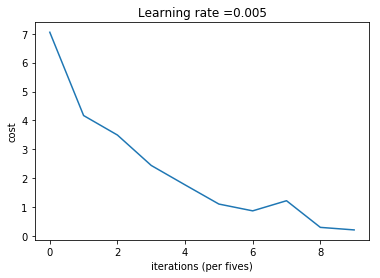

Test Accuracy:  0.785714


In [19]:
parameters, prediction = model(train_X, train_Y, test_X, test_Y, None, None,
                   num_epochs=50, learning_rate = 0.005, 
                   mini_batch_size = 10, l2_regularize=False, beta=0.02)

In [ ]:
parameters

In [ ]:
p = None

init = tf.global_variables_initializer()  

with tf.Session() as sess:
    sess.run(init)
    p = sess.run(parameters)

p 

In [ ]:
X, Y = create_placeholders(train_X.shape[0], 3)

init = tf.global_variables_initializer()  

with tf.Session() as sess:
    sess.run(init)
    print(prediction.eval({X:train_X[:, 0:1]}))

In [14]:
def run_testset_accuracy(params, index):
    
    X, Y = create_placeholders(train_X.shape[0], 3)
    
    Z3 = forward_prop(X, params)
    sm = tf.argmax(Z3)            
    feed_dict = {X: test_X[:, index:index+1]}
    
    init = tf.global_variables_initializer()    
    
    with tf.Session() as sess:
        sess.run(init)
        op = sess.run(sm, feed_dict)
        return op[0]    

In [15]:
def convert_params_to_tensors(parameters):
    param = {}
    for key, val in parameters.items():
        param[key] = tf.convert_to_tensor(val)
    
    return param

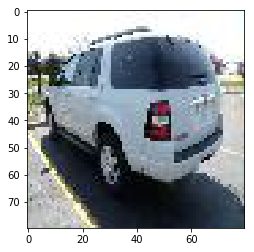

Original class | Predicted class => Back Left | Back Left


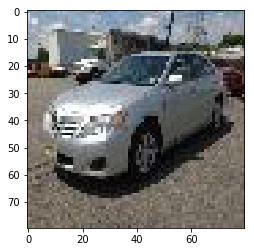

Original class | Predicted class => Front Left | Front Left


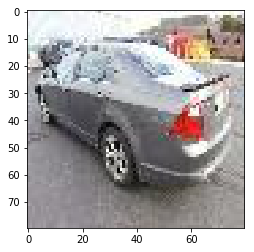

Original class | Predicted class => Back Left | Back Left


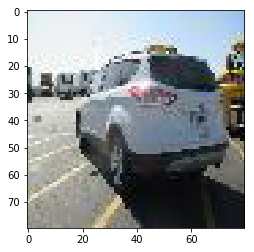

Original class | Predicted class => Back Left | Back Left


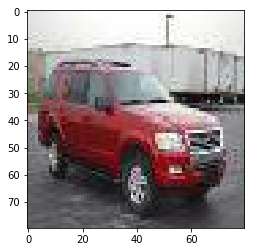

Original class | Predicted class => Front Right | Front Right


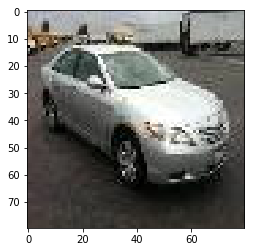

Original class | Predicted class => Front Right | Front Right


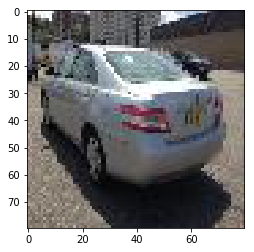

Original class | Predicted class => Back Left | Back Left


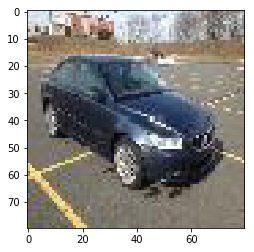

Original class | Predicted class => Front Right | Front Right


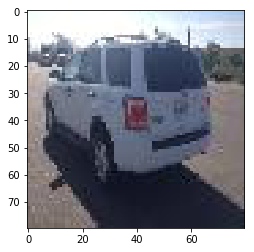

Original class | Predicted class => Back Left | Back Left


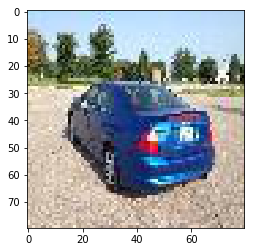

Original class | Predicted class => Back Left | Front Right


In [22]:
pos_map = {0: 'Front Right', 1: 'Front Left', 2: 'Back Left'}
l = list(range(test_X.shape[1]))
import random
random.shuffle(l)
a = l[:10]
#print(a)

params = convert_params_to_tensors(parameters)

for index in a:
    actual_class = show_image(test_X, test_Y, index, dimension=(80, 80))    
    klazz = run_testset_accuracy(params, index)
    print("Original class | Predicted class => %s | %s" % (pos_map[actual_class], pos_map[klazz]) )

In [7]:
def tanh_derivative(Z):
    A = np.tanh(Z)
    return 1 - np.power(A, 2)

In [8]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [9]:
def relu(Z):
    return np.maximum(0, Z)

In [10]:
def relu_derivative(Z):
    return np.int64(Z > 0)
    #res = np.copy(Z)
    #res[(Z >= 0)] = 1
    #res[(Z < 0)] = 0
    #return res    


In [11]:
def sigmoid_derivative(Z):
    A = sigmoid(Z)
    return A * (1 - A)

In [12]:
sigmoid(np.array([10,10,-10]))
print(np.sum( np.ones((1,4))))
print(relu(np.array([10,10,-10,0])))
print(relu_derivative(np.array([10,10,-10,0])))

4.0
[10 10  0  0]
[1 1 0 0]


In [13]:
def make_activation(func_name):
    if func_name == 'sigmoid':
        return (sigmoid, sigmoid_derivative)
    elif func_name == 'tanh':
        return (np.tanh, tanh_derivative)
    elif func_name == 'relu':
        return (relu, relu_derivative)    

In [14]:
s, sd = make_activation('tanh')
print(sd.__name__)
print(sd( s(0) ))

tanh_derivative
1.0


In [15]:
#a= np.array([[0.2,0.5,0.1], [0.9,0.5,0.6]])
a= np.array([[0.2,0.5,0.6]])
print(str(a) + " " + str(a.shape))
b = (a > 2)
print(str(b))
a[a > 0.5] = 1
a[a <= 0.5] = 0

print(str(a))

[[ 0.2  0.5  0.6]] (1, 3)
[[False False False]]
[[ 0.  0.  1.]]


In [16]:
def forward_prop(X, Y, activation, parameters, layers):
    
    forward_cache = {"A0":X}
    
    for i in range(1, len(layers)+1):
        #print("in forward layer " + str(i))
        W, b = parameters["W"+str(i)], parameters["b"+str(i)]
        A = forward_cache["A"+str(i-1)]
        Z = np.dot(W, A) + b
        forward_cache["Z"+str(i)] = Z
        if i == len(layers):
            forward_cache["A"+str(i)] = sigmoid(Z)   
        else:
            forward_cache["A"+str(i)] = activation(Z)   
    
    return forward_cache

In [17]:
def forward_prop_with_dropout(X, Y, activation, parameters, layers, keep_prob):
    forward_cache = {"A0":X}
    
    for i in range(1, len(layers)+1):
        #print("in forward layer " + str(i))
        W, b = parameters["W"+str(i)], parameters["b"+str(i)]
        A = forward_cache["A"+str(i-1)]
        Z = np.dot(W, A) + b
        forward_cache["Z"+str(i)] = Z
        if i == len(layers):
            forward_cache["A"+str(i)] = sigmoid(Z)   
        else:
            A = activation(Z)
            D = (np.random.rand(A.shape[0], A.shape[1]) < keep_prob)
            A = A * D
            A = A/keep_prob
            forward_cache["A"+str(i)] = A
            forward_cache["D"+str(i)] = D
    
    return forward_cache    

In [18]:
def compute_cost(forward_cache, Y, num_layers, m):
    AL = forward_cache["A"+str(num_layers)]
    
    loss = np.sum(Y * np.log(AL) + (1-Y) * np.log(1-AL))        
    cost = -1/m * loss
    
    #print("loss and cost " + str(loss) + ", " + str(cost))
    return cost

In [19]:
def compute_cost_L2_regulariation(forward_cache, parameters, Y, num_layers, m, lambd):
    cross_entropy_cost = compute_cost(forward_cache, Y, num_layers, m)
    
    wt_square=0
    for i in range(1, num_layers+1):
        wt_square = wt_square + np.sum(np.square(parameters["W"+str(i)]))
    
    L2_regulariation_cost = 1/m * lambd/2 * wt_square
    
    #print("loss and cost " + str(loss) + ", " + str(cost))
    return cross_entropy_cost + L2_regulariation_cost

In [20]:
def backward_prop_L2_regulariation(X, Y, activation_deriv, parameters, forward_cache, num_layers, m, lambd):
    AL = forward_cache["A"+str(num_layers)]
    
    # derivative of loss function
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    backprop_cache = {}
    
    # computing backprop for each layer from end to start
    for i in range(num_layers, 0, -1):        
        #print("in back prop layer " + str(i))
        if i == num_layers:
            backprop_cache["dZ"+str(i)] = dAL * sigmoid_derivative(forward_cache["Z"+str(i)])
        else:
            A = forward_cache["A"+str(i)]
            g_prime_z = None
            if activation_deriv.__name__ == 'sigmoid_derivative':
                g_prime_z = A * (1 - A)
            elif activation_deriv.__name__ == 'tanh_derivative':
                g_prime_z = 1 - np.power(A, 2)
            else:
                g_prime_z = activation_deriv(forward_cache["Z"+str(i)])
                
            backprop_cache["dZ"+str(i)] = dAL * g_prime_z
            
        dZl = backprop_cache["dZ"+str(i)]        
        backprop_cache["dW"+str(i)] = 1/m * np.dot(dZl, forward_cache["A"+str(i-1)].T) + (lambd/m * parameters["W"+str(i)])
            
        backprop_cache["db"+str(i)] = 1/m * np.sum(dZl, axis=1, keepdims=True)
        dAL = np.dot(parameters["W"+str(i)].T, dZl)
    
    return backprop_cache

In [21]:
def backward_prop(X, Y, activation_deriv, parameters, forward_cache, num_layers, m):
    AL = forward_cache["A"+str(num_layers)]
    
    # derivative of loss function
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    backprop_cache = {}
    
    # computing backprop for each layer from end to start
    for i in range(num_layers, 0, -1):        
        #print("in back prop layer " + str(i))
        if i == num_layers:
            backprop_cache["dZ"+str(i)] = dAL * sigmoid_derivative(forward_cache["Z"+str(i)])
        else:
            A = forward_cache["A"+str(i)]
            g_prime_z = None
            if activation_deriv.__name__ == 'sigmoid_derivative':
                g_prime_z = A * (1 - A)
            elif activation_deriv.__name__ == 'tanh_derivative':
                g_prime_z = 1 - np.power(A, 2)
            else:
                g_prime_z = activation_deriv(forward_cache["Z"+str(i)])
                
            backprop_cache["dZ"+str(i)] = dAL * g_prime_z
            
        dZl = backprop_cache["dZ"+str(i)]        
        backprop_cache["dW"+str(i)] = 1/m * np.dot(dZl, forward_cache["A"+str(i-1)].T)
        backprop_cache["db"+str(i)] = 1/m * np.sum(dZl, axis=1, keepdims=True)
        dAL = np.dot(parameters["W"+str(i)].T, dZl)
    
    return backprop_cache

In [22]:
def backward_prop_with_dropout(X, Y, activation_deriv, parameters, forward_cache, num_layers, m, keep_prob):
    AL = forward_cache["A"+str(num_layers)]
    
    # derivative of loss function
    dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    backprop_cache = {}
    
    # computing backprop for each layer from end to start
    for i in range(num_layers, 0, -1):        
        #print("in back prop layer " + str(i))
        if i == num_layers:
            backprop_cache["dZ"+str(i)] = dAL * sigmoid_derivative(forward_cache["Z"+str(i)])
        else:
            A = forward_cache["A"+str(i)]
            g_prime_z = None
            if activation_deriv.__name__ == 'sigmoid_derivative':
                g_prime_z = A * (1 - A)
            elif activation_deriv.__name__ == 'tanh_derivative':
                g_prime_z = 1 - np.power(A, 2)
            else:
                g_prime_z = activation_deriv(forward_cache["Z"+str(i)])
            
            D = forward_cache["D"+str(i)]   # get the dropout matrix for this layer
            dAL = dAL * D
            dAL = dAL/keep_prob                
            backprop_cache["dZ"+str(i)] = dAL * g_prime_z
            
        dZl = backprop_cache["dZ"+str(i)]        
        backprop_cache["dW"+str(i)] = 1/m * np.dot(dZl, forward_cache["A"+str(i-1)].T)
        backprop_cache["db"+str(i)] = 1/m * np.sum(dZl, axis=1, keepdims=True)
        dAL = np.dot(parameters["W"+str(i)].T, dZl)
    
    return backprop_cache

In [23]:
def predict(parameters, X, Y, activation, layers):
    #(n_x, m) = X.shape    
    
    cache = forward_prop(X, Y, activation, parameters, layers)
    #prediction = np.zeros((1,m))  
    
    AL = cache["A"+str(len(layers))]    
    prediction = np.copy(AL)
    prediction[prediction > 0.5] = 1
    prediction[prediction <= 0.5] = 0
    
    #for i in range(AL.shape[1]):
     #   if AL[0][i] > 0.5:
      #      prediction[0][i] = 1
    
    return prediction

In [38]:
def predict1(parameters, X, Y, t_Y, activation, layers):
    #(n_x, m) = X.shape    
    
    cache = forward_prop(X, Y, activation, parameters, layers)
    #prediction = np.zeros((1,m))  
    
    AL = cache["A"+str(len(layers))]    
    a = np.argmax(AL, axis=0)
    prediction = sum(int(x == y)  for x, y in zip(a, t_Y[0]))
    
    return prediction, a

In [25]:
a = np.random.rand(2,4)

print(a)
a[a > 0.5] = 1
a[a <= 0.5] = 0
print(a)
b = np.argmax(a, axis=0)
for i in b:
    print(i)

c = np.random.rand(1,4)
print(c)
for i,j in zip(b, c[0]):
    print(i)
    print(j)

[[ 0.74028654  0.20610096  0.02241014  0.07338663]
 [ 0.04545422  0.63881097  0.61567655  0.28479606]]
[[ 1.  0.  0.  0.]
 [ 0.  1.  1.  0.]]
0
1
1
0
[[ 0.11331645  0.21417325  0.29280649  0.91353842]]
0
0.113316453347
1
0.214173253312
1
0.292806488166
0
0.913538415018


In [26]:
def init_parameters(inp_features, layers):
    total_layers = []
    total_layers.append(inp_features)
    total_layers.extend(layers)
    
    i=1    
    parameters = {}
    for (nx, ny) in zip(total_layers[1:], total_layers[:-1]):
        parameters["W"+str(i)] = np.random.randn(nx, ny) * np.sqrt(2 / ny)  # He initialization
        parameters["b"+str(i)] = np.zeros((nx, 1))
        i = i+1
    
    return parameters

In [27]:
def update_parameters(parameters, backprop_cache, num_layers, learning_rate):
    for i in range(1, num_layers+1):
        parameters["W"+str(i)] = parameters["W"+str(i)] - (learning_rate * backprop_cache["dW"+str(i)])
        parameters["b"+str(i)] = parameters["b"+str(i)] - (learning_rate * backprop_cache["db"+str(i)])
    
    return parameters

In [28]:
def dd(p):
    p["a"] = 1
    return p

In [29]:
a={"a":2}
print(dd(a))
b = np.array([[1,4,7,3,4,10]])
print(b > 3)

{'a': 1}
[[False  True  True False  True  True]]


In [30]:
layers = [5,1]
param = init_parameters(10, layers)
for i in range(1, len(layers)+1):
    print(param["W"+str(i)].shape)
    print(param["b"+str(i)].shape)    

(5, 10)
(5, 1)
(1, 5)
(1, 1)


In [31]:
def train(X, Y, activation_func, layers, num_iterations=2, learning_rate=0.5, lambd=0, keep_prob=1, 
          monitor_train_accuracy=False, test_data=None, monitor_test_accuracy=False):
    
    print("In train, lambda {}".format(lambd))
    
    activation, activation_deriv = activation_func
    (n_x, m) = X.shape
    print(n_x, m)
    #n_h, n_y = 5, 1
    # initialize wt and b
    parameters = init_parameters(n_x, layers)  
    
    train_accuracy, test_accuracy = [], []
    
    for i in range(num_iterations):
        
        if keep_prob == 1:
            forward_cache = forward_prop(X, Y, activation, parameters, layers)
        elif keep_prob < 1:
            forward_cache = forward_prop_with_dropout(X, Y, activation, parameters, layers, keep_prob)       
        
        
        if lambd == 0:
            cost = compute_cost(forward_cache, Y, len(layers), m)
        else:
            cost = compute_cost_L2_regulariation(forward_cache, parameters, Y, len(layers), m, lambd)
        
        if i % 100 == 0:
            print("cost after " + str(i) + " iterations " + str(cost))
            if monitor_train_accuracy:
                train_prediction = predict(parameters, train_X, train_Y, activation, layers)
                train_accuracy.append(100 -  np.mean(np.abs(train_Y - train_prediction)) * 100)
            if monitor_test_accuracy:
                test_X, test_Y = test_data
                test_prediction = predict(parameters, test_X, test_Y, activation, layers)
                test_accuracy.append(100 -  np.mean(np.abs(test_Y - test_prediction)) * 100)
        
        if lambd == 0 and keep_prob == 1:
            backprop_cache = backward_prop(X, Y, activation_deriv, parameters, forward_cache, len(layers), m)
        elif lambd != 0:
            backprop_cache = backward_prop_L2_regulariation(X, Y, activation_deriv, parameters, 
                                                            forward_cache, len(layers), m, lambd)
        elif keep_prob < 1:
            backprop_cache = backward_prop_with_dropout(X, Y, activation_deriv, parameters, 
                                                        forward_cache, len(layers), m, keep_prob)
        
        parameters = update_parameters(parameters, backprop_cache, len(layers), learning_rate)   
        
        
    
    
    if monitor_train_accuracy:
        plt.plot(train_accuracy)
        plt.ylabel('train accuracy')
        plt.xlabel('iterations X 100')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
    if monitor_test_accuracy:
        plt.plot(test_accuracy)
        plt.ylabel('test accuracy')
        plt.xlabel('iterations X 100')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
        
    
    return parameters

In [52]:
activation_funcname = 'relu'
layers = [5, 3]
for lambdaa in [0]:
#for lambdaa in [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]:
    parameters = train(train_X, train_Y, make_activation(activation_funcname), layers, num_iterations=1000, 
                   learning_rate=0.005, lambd=lambdaa, keep_prob=1, 
                       monitor_train_accuracy=True, 
                       test_data=(test_X, test_Y), monitor_test_accuracy=True)
    
    activation, activation_deriv = make_activation(activation_funcname)
    #train_prediction = predict(parameters, train_X, train_Y, activation, layers)
    train_prediction = predict1(parameters, train_X, train_Y, t_train_Y, activation, layers)
    
    test_prediction = predict(parameters, test_X, test_Y, activation, layers)
    print("train accuracy : {} %".format(100 -  np.mean(np.abs(train_Y - train_prediction)) * 100) )
    print("dev set accuracy : {} %".format(100 -  np.mean(np.abs(test_Y - test_prediction)) * 100) )
    mislabeled = [ index for index, (val, val1) in enumerate( zip(test_Y[0], test_prediction[0]) ) if val != val1 ]
    print("length of mislabel images {}".format(len(mislabeled)))
    #print(mislabeled)


In train, lambda 0
25122 650
cost after 0 iterations 1.98874099281
cost after 100 iterations 1.21655494586
cost after 200 iterations 1.09269747048


KeyboardInterrupt: 

In [37]:
activation_funcname = 'relu'
layers = [20, 10, 3]
for lambdaa in [0]:
#for lambdaa in [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]:
    parameters = train(train_X, train_Y, make_activation(activation_funcname), layers, num_iterations=2500, 
                   learning_rate=0.005, lambd=lambdaa, keep_prob=1, 
                       monitor_train_accuracy=False, 
                       test_data=(test_X, test_Y), monitor_test_accuracy=False)
    
    activation, activation_deriv = make_activation(activation_funcname)
    #train_prediction = predict(parameters, train_X, train_Y, activation, layers)
    train_prediction = predict1(parameters, train_X, train_Y, t_train_Y, activation, layers)
    
    
    print("train accuracy : {}".format(train_prediction) )
    


In train, lambda 0
25122 650
cost after 0 iterations 2.09505763591
cost after 100 iterations 1.66846958067
cost after 200 iterations 1.35267732261
cost after 300 iterations 0.985745546046
cost after 400 iterations 0.864968291187
cost after 500 iterations 0.740948296608
cost after 600 iterations 0.693602628654
cost after 700 iterations 0.639177834348
cost after 800 iterations 0.629233966951
cost after 900 iterations 0.72144784504
cost after 1000 iterations 0.462442927303
cost after 1100 iterations 0.257451296722
cost after 1200 iterations 0.232200076841
cost after 1300 iterations 0.18572252465
cost after 1400 iterations 0.146857422223
cost after 1500 iterations 0.121529462796
cost after 1600 iterations 0.0949745885595
cost after 1700 iterations 0.0785506426716
cost after 1800 iterations 0.0635516803639
cost after 1900 iterations 0.0521640857249
cost after 2000 iterations 0.0436455997355
cost after 2100 iterations 0.0373630890508
cost after 2200 iterations 0.0324911792686
cost after 2300

prediction label 2


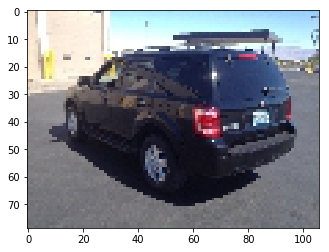

In [39]:
index = 32
p, a = predict1(parameters, train_X, train_Y, t_train_Y, activation, layers)

print("prediction label " + str(a[index]))
show_image(train_X, train_Y, index)

test label 0
test accuracy 134


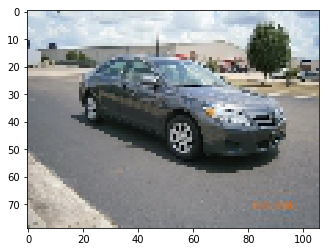

In [66]:
index = 304
#p, a = predict1(parameters, train_X, train_Y, t_train_Y, activation, layers)

#print("prediction label " + str(a[index]))
#w_image(train_X, train_Y, index)

t_test_Y = np.argmax(test_Y, axis=0)
#a = np.array(t_test_Y)
t_test_Y = t_test_Y.reshape(1, 169)
index = 16
print("test label " + str(t_test_Y[0][index]))
show_image(test_X, test_Y, index)
p, a = predict1(parameters, test_X, test_Y, t_test_Y, activation, layers)
print("test accuracy " + str(p))

In [127]:
l=[0,1,1,1,0,1,0]
a = np.empty((2, len(l)))
a.shape
a[:, :1] = np.ones((2,1))
#a[:, :1].shape
a

def one_hot_encoding(Y, classes, ):
    one_hot = np.empty((classes, len(Y.shape[1])))
    
    for i in range(Y.shape[1]):
        one_hot[Y[0][i], i] = 1
    
    return one_hot

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [146]:
a = np.zeros((3,3))
a[2, 2] = 1
a

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.]])

In [156]:
def one_hot_encoding(Y, classes):
    one_hot = np.zeros((classes, Y.shape[1]))
    
    for i in range(Y.shape[1]):
        one_hot[Y[0][i], i] = 1
    
    return one_hot

In [158]:
a = one_hot_encoding(np.array([[0,1,2,0,1,3]]), 4)
#a.shape
a

array([[ 1.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])